# Analyze Dataset
---
1. Encode email data using BERT.
2. Split data into test and train splits.
3. Train an SVM model to predict the class of an email.
4. Test the model on unseen emails.

## Imports

In [4]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import torch
import joblib
import platform

## Load Data

In [2]:
email_dataframe = pd.read_feather("../data/2_balanced_email_dataset.feather")

# Encode "Email Type" into a numerical format: 0 for ham, 1 for phishing, and 2 for spam
email_dataframe["label_id"] = email_dataframe["Email Type"].astype("category").cat.codes

## Encode Email Text using SBERT

Activate CUDA if available.

In [6]:
def get_device_type():
    if platform.system() in ["Windows", "Linux"]:
        return "cuda" if torch.cuda.is_available() else "cpu"
    elif platform.system() == "Darwin":
        return "mps" if torch.backends.mps.is_available() else "cpu"
    else:
        return "cpu"

device = get_device_type()

# Store the variable to be used in 5. Demo Classify Emails.ipynb
%store device

print("Using device:", device)

Stored 'device' (str)
Using device: cuda


In [36]:
# Labels
X = email_dataframe["Email Text"]
y = email_dataframe["label_id"]

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [37]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=20000)

# Fit the vectorizer only on the training data and transform both sets
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Original training samples: {X_train.shape[0]}")
print(f"Vectorized training samples (Features): {X_train_tfidf.shape}")

Original training samples: 41210
Vectorized training samples (Features): (41210, 20000)


In [6]:
# tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=2000, ngram_range=(1, 2))

# # Fit the vectorizer only on the training data and transform both sets
# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# X_test_tfidf = tfidf_vectorizer.transform(X_test)

# print(f"Original training samples: {X_train.shape[0]}")
# print(f"Vectorized training samples (Features): {X_train_tfidf.shape}")

In [38]:
# Train SVM classifier
model = SVC(kernel="linear", C=1.0, class_weight="balanced", random_state=42)
model.fit(X_train_tfidf, y_train)

# Predict
y_pred = model.predict(X_test_tfidf)

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3399
           1       0.99      0.99      0.99      3374
           2       1.00      1.00      1.00      3530

    accuracy                           0.99     10303
   macro avg       0.99      0.99      0.99     10303
weighted avg       0.99      0.99      0.99     10303



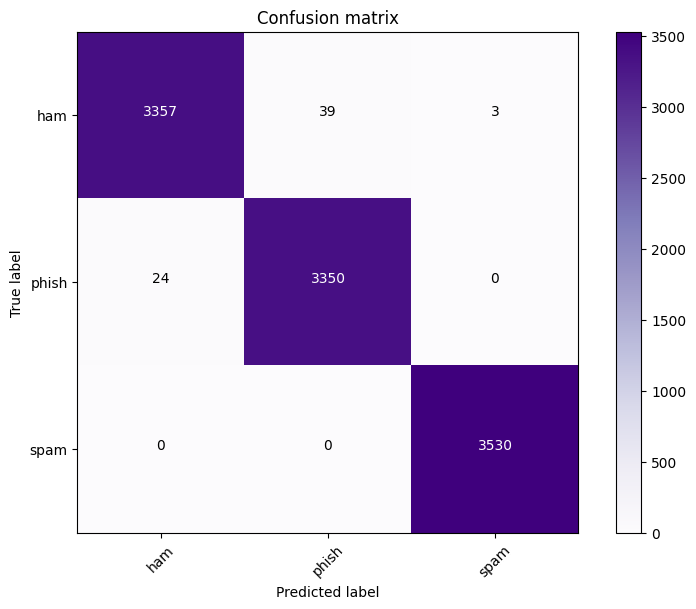

In [40]:
cm = confusion_matrix(y_test, y_pred)
class_names = email_dataframe["Email Type"].unique()


plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

fmt = 'd'
threshold = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


Save as `.joblib` file for later reuse.

In [41]:
Path("../models").mkdir(parents=True, exist_ok=True)
joblib.dump(model, "../models/svm_model_2.joblib")

['../models/svm_model_2.joblib']